<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## ***DATA SCIENCE / SECTION 4 / SPRINT 2 / NOTE 3***

---

# 언어 모델과 RNN(Recurrent Neural Network, 순환 신경망)

In [32]:
# 더 알아보기 : 파이썬의 딕셔너리도 비슷한 형태로 작동합니다.
# Query('a')를 던지면 딕셔너리에서 동일한 Key('a')를 찾은 뒤 Value(123)을 반환합니다.

dict1 = {'a':123, 'b':425, 'c':236, 'd':945}
dict1['a']

123

### RNN(LSTM) with Attention 코드 실습

`Tensorflow` 튜토리얼 코드를 사용하여 Attention이 어떻게 적용되는 지 알아보도록 하겠습니다.

In [33]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [34]:
# 데이터셋을 다운로드합니다.
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [35]:
# 유니코드 파일을 아스키코드로 변환하는 함수입니다.
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                 if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [36]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [37]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  
  word_pairs = [[preprocess_sentence(w) for w in line.split('\t')]
                for line in lines[:num_examples]]


  return zip(*word_pairs)

In [38]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [39]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [40]:
# 2개 언어이기 때문에, tokenizer가 각각의 언어별로 따로 필요합니다.
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)
  
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [41]:
# load할 dataset의 개수를 30000으로 설정
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# target과 input의 최대 길이 구하기(문장 최대 길이)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [42]:
targ_lang

In [43]:
# 8:2 비율로 train-test split 진행
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 데이터 개수 뽑아보기
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


- 구조와 관련된 파라미터 설정하기

In [44]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

# tf.data.Dataset -> 텐서플로우에서 제공하는 Dataset 클래스입니다.
# Dataset 클래스는 배치 구성, 데이터셋 셔플, 윈도우 구현, 변환 함수 적용 등 다양한 기능을 제공합니다.
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [46]:
next(iter(dataset))

(<tf.Tensor: shape=(64, 16), dtype=int32, numpy=
 array([[   1,   10,    4, ...,    0,    0,    0],
        [   1,  780,  812, ...,    0,    0,    0],
        [   1,    8,  146, ...,    0,    0,    0],
        ...,
        [   1,   67, 8451, ...,    0,    0,    0],
        [   1,   12,  896, ...,    0,    0,    0],
        [   1,    6,   11, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 11), dtype=int32, numpy=
 array([[   1,    5, 1456, 3811,    3,    2,    0,    0,    0,    0,    0],
        [   1,   16,  108,   36,    3,    2,    0,    0,    0,    0,    0],
        [   1,    4,   87,   12, 1022,    3,    2,    0,    0,    0,    0],
        [   1,   28,  230,   81,    3,    2,    0,    0,    0,    0,    0],
        [   1,   71,    8,   27,    7,    2,    0,    0,    0,    0,    0],
        [   1,    4,   76, 2091,    3,    2,    0,    0,    0,    0,    0],
        [   1,   14, 4322,   55,   13,  642,    3,    2,    0,    0,    0],
        [   1,   10,  169,   65,  160,    5,    

In [ ]:
# 첫 번째 배치 뽑아보기
# input_batch의 경우, 총 64개 데이터로 이루어져 있고, 1개 문장이 16개 단어로 이루어져 있습니다.
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

- 인코더 구현하기

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    # |x| = (batch_sz, seq_len)
    x = self.embedding(x) # |x| = (batch_sz, seq_len, embedding_dim)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
# sample input을 통해 Encoder 레이어 결과값의 shape을 확인해보겠습니다
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    # W1(query_with_time_axis) == (batch_size, 1, units)
    # W2(values) == (batch_size, max_len, units)
    # W1(query_with_time_axis) + W2(values) == (batch_size, max_len, units)
    # V(tf.nn.tanh(W1(query_with_time_axis) + W2(values))) == (batch_size, max_len, 1)

    attention_weights = tf.nn.softmax(score, axis=1) # attention_weights == (batch_size, max_length, 1)

    context_vector = attention_weights * values # context_vector == (batch_size, max_len, hidden_size)
    context_vector = tf.reduce_sum(context_vector, axis=1) # context_vector == (batch_size, hidden_size)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


- **디코더 구현**

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # x == (batch_size, 1)
    # hidden == (batch_size, hidden_size)
    # enc_output shape == (batch_size, max_length, hidden_size)

    context_vector, attention_weights = self.attention(hidden, enc_output)
    # context_vector == (batch_size, hidden_size)
    # attention_weights == (batch_size, max_length, 1)

    x = self.embedding(x) # x == (batch_size, 1, embedding_dim)

    # tf.expand_dims(context_vector, 1) == (batch_size, 1, hidden_size)
    # tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) == (batch_size, 1, embedding_dim+hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    # output == (batch_size, 1, hidden_size)
    # state == (batch_size, hidden_size)
    output, state = self.gru(x)

    
    output = tf.reshape(output, (-1, output.shape[2])) # output  == (batch_size * 1, hidden_size)

    x = self.fc(output) # x == (batch_size, vocab)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Teacher Forcing
- seq2seq에서 decoder의 예측값이 아닌 실제 정답인 target을 다음 타임 스텝의 입력으로 넣어주는 방법을 Teacher Forcing이라고 합니다.
- 장점
  - 만약 decoder가 엉뚱한 대답을 내놓더라도, 학습 시 실제 정답을 넣어주기 때문에 seq2seq 학습에 안정성을 더해줍니다.
- 단점
  - 실제 학습과 추론 코드를 각각 구성해야 합니다.
  - 학습과 추론 사이의 괴리가 존재합니다.

>❗️  Teacher forcing은 지금 반드시 알아야 하는 개념이 아닙니다. N424에서 다룰 Transformer에서는 더이상 사용되지 않는 방법론이기도 합니다.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
      
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6026
Epoch 1 Batch 100 Loss 2.1524
Epoch 1 Batch 200 Loss 1.8952
Epoch 1 Batch 300 Loss 1.6539
Epoch 1 Loss 2.0383
Time taken for 1 epoch 1016.7628138065338 sec

Epoch 2 Batch 0 Loss 1.5593
Epoch 2 Batch 100 Loss 1.4487
Epoch 2 Batch 200 Loss 1.2338
Epoch 2 Batch 300 Loss 1.3027
Epoch 2 Loss 1.3807
Time taken for 1 epoch 992.9955353736877 sec

Epoch 3 Batch 0 Loss 1.0330
Epoch 3 Batch 100 Loss 1.0200
Epoch 3 Batch 200 Loss 0.8721
Epoch 3 Batch 300 Loss 0.9157
Epoch 3 Loss 0.9653
Time taken for 1 epoch 989.1491215229034 sec

Epoch 4 Batch 0 Loss 0.6319
Epoch 4 Batch 100 Loss 0.6260
Epoch 4 Batch 200 Loss 0.5699
Epoch 4 Batch 300 Loss 0.7347
Epoch 4 Loss 0.6478
Time taken for 1 epoch 986.2824234962463 sec

Epoch 5 Batch 0 Loss 0.4384
Epoch 5 Batch 100 Loss 0.3671
Epoch 5 Batch 200 Loss 0.4387
Epoch 5 Batch 300 Loss 0.4493
Epoch 5 Loss 0.4406
Time taken for 1 epoch 998.4929230213165 sec

Epoch 6 Batch 0 Loss 0.2667
Epoch 6 Batch 100 Loss 0.2406
Epoch 6 Batch 200 Los

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


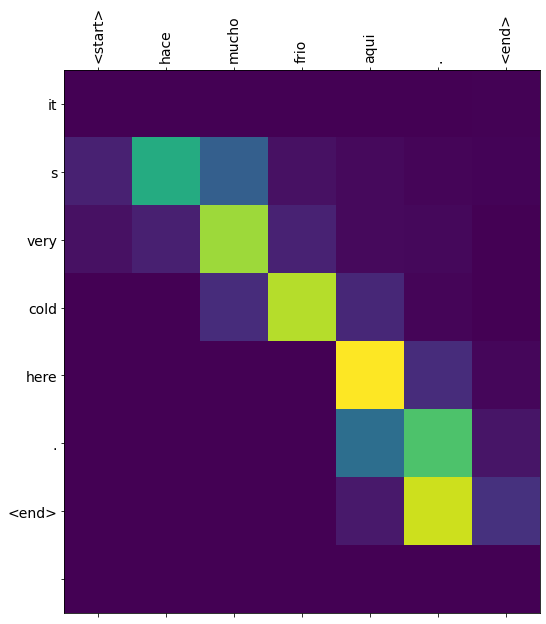

In [ ]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


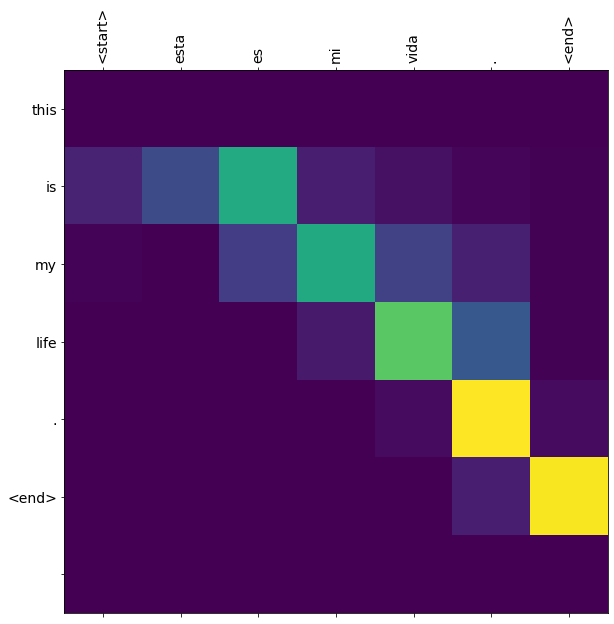

In [ ]:
translate(u'esta es mi vida.')

## Review

- 언어 모델 (Language Model)
    - 통계 기반의 언어 모델(Statistical Language Model)
    - 신경망 언어 모델(Neural Network Language Model) 

- 순환 신경망 (Recurrent Neural Network, RNN)
    - RNN의 구조
    - RNN의 장점과 단점
        - 기울기 소실(Gradient Vanishing)

- LSTM & GRU
    - LSTM
        - Cell state
    - GRU

- Attention
    - Attention
        - 장기 의존성(Long-term Dependency)
    - Query, Key, Vector
        - 어떤 벡터가 각 요소에 해당될까요?